# Trick Taking Game

## Introduction

A trick-taking game is a card game in which players take turns playing cards and the highest card played each round wins the trick. There is often a trump suit that beats all other suits, and players must follow suit if possible. The game is played over a series of rounds, with each round consisting of a number of tricks. The player or team that wins the most tricks wins the game. There are many different trick-taking games, but they all share some common elements. The most common trick-taking games are Bridge, Whist, Hearts, and Spades.
 
In this project, I'll be looking at simulated data from one round of a trick-taking game. The data was generated using a simple trick-taking game with the following rules:
- The game is played with a standard deck of 52 cards.
- There are four players, each of whom is dealt 8 cards.
- There is a trump suit dealt randomly at the beginning of the round.
 
The data consists of the number information about each players hands (number of high cards (J,Q,K,A), number of low cards (2,3,4,5), percent of trump cards, suit impurity, if the player was leading the round, and how many tricks they won). The goal is to predict the number of tricks each player will win in the round.

In [19]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import train_test_split

## Data Preparation
We only want to look at the player using the stratgy SimpleWinTricks, not the random players.
We also want to normalize the high card and low card count to be a percentage of the total cards in the hand.

In [20]:
df = pd.read_csv("data/output-4-8.csv")

In [21]:
df = df[df["strategy"] == "SimpleWinTricks"]
df["high_card_percentage"] = df["high_card_count"] / df["num_tricks"]
df["low_card_percentage"] = df["low_card_count"] / df["num_tricks"]
df["leading"] = df["leading"].astype(int)
df.head()

,suit_impurity,trump_percentage,high_card_count,low_card_count,leading,strategy,trump_suit,num_tricks,num_players,tricks_taken,high_card_percentage,low_card_percentage
2,0.71875,0.25,3,3,0,SimpleWinTricks,C,8,4,4,0.375,0.375
6,0.71875,0.25,3,3,0,SimpleWinTricks,C,8,4,2,0.375,0.375
10,0.71875,0.25,3,3,0,SimpleWinTricks,C,8,4,2,0.375,0.375
14,0.71875,0.25,3,3,0,SimpleWinTricks,C,8,4,2,0.375,0.375
18,0.71875,0.25,3,3,0,SimpleWinTricks,C,8,4,2,0.375,0.375


There are no missing values in the data, so we don't need to worry about imputing missing values. We also don't need to worry about encoding categorical variables, as all of the variables are numeric.

In [22]:
# Drop unnecessary columns
df = df.drop(
    [
        "strategy",
        "trump_suit",
        "num_players",
        "num_tricks",
        "high_card_count",
        "low_card_count",
    ],
    axis=1,
)

In [23]:
df.describe()

,suit_impurity,trump_percentage,leading,tricks_taken,high_card_percentage,low_card_percentage
count,1600.000000,1600.000000,1600.000000,1600.000000,1600.000000,1600.000000
mean,0.682031,0.250000,0.500000,2.415625,0.309375,0.312500
std,0.047350,0.130395,0.500156,1.399234,0.165382,0.167758
min,0.562500,0.000000,0.000000,0.000000,0.000000,0.125000
25%,0.656250,0.125000,0.000000,1.000000,0.218750,0.125000
50%,0.703125,0.250000,0.500000,2.000000,0.250000,0.250000
75%,0.718750,0.375000,1.000000,3.000000,0.375000,0.406250
max,0.750000,0.625000,1.000000,6.000000,0.875000,0.750000


## Model - Linear Regression
We will use a Linear Regression model to predict the number of tricks each player will win in the round.

In [24]:
X = df.drop(["tricks_taken"], axis=1)
y = df["tricks_taken"]

In [25]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [26]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

## Evaluate

In [27]:
lr.score(X_test, y_test)

0.4976725555289865

In [28]:
lr.coef_

array([-2.87152871,  5.38635792,  0.16544458,  3.36649007, -1.31469595])

In [29]:
root_mean_squared_error(y_test, lr.predict(X_test))

np.float64(0.9733635772260284)

The coefficients of the model will give us an idea of which features are most important in predicting the number of tricks won. We can also look at the mean squared error of the model to see how well it performs on the test data.

The coeffients are as follows:
- Suit Impurity: -2.87
- Trump Percentage: 5.39
- Leading: 0.165
- High Card Percentage: 3.37
- Low Card Percentage: -1.31

From this we can see that the Trump Percentage and High Card Percentage are the most important features in predicting the number of tricks won. The Suit Impurity and Low Card Percentage are less important, and Leading is the least important. The data was normalized, but not standardized, so the coefficients are not directly comparable.

Suit Impurity and Low Card Percentage are negatively correlated. This makes sense since having more low cards in your hand is generally a disadvantage, and having a hand with more of the same suit (less impurity) is an advantage.

The root mean squared error of the model is 0.97, which means that the model is off by about 1 trick on average. This is not bad considering that the number of tricks won is an integer value between 0 and 8.

In [30]:
def actual_vs_predicted_plot(y_predict, y_actual):
    plt.scatter(y_predict, y_actual)
    plt.plot([0, 6], [0, 6], "r-", lw=1)
    plt.xlabel("Predicted Tricks Taken")
    plt.ylabel("Actual Tricks Taken")
    plt.title("Predicted vs Actual Tricks Taken")
    plt.show()

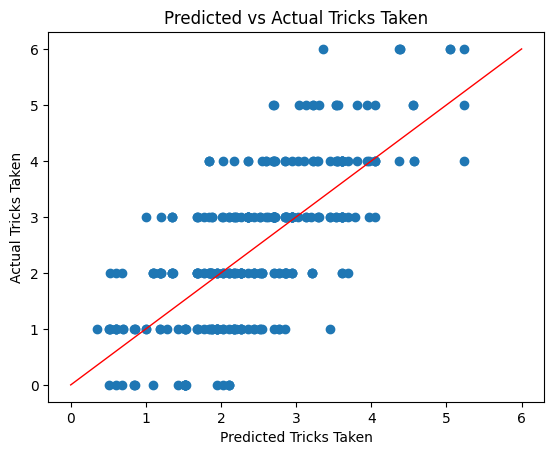

In [31]:
y_predict = lr.predict(X_test)
y_actual = y_test

# Plot the predicted vs actual
actual_vs_predicted_plot(y_predict, y_actual)

## Model - Random Forest

In [32]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [33]:
rf.score(X_test, y_test)

0.5847308129393739

In [34]:
rf.feature_importances_

array([0.11297993, 0.3746191 , 0.04791552, 0.34107957, 0.12340589])

In [35]:
root_mean_squared_error(y_test, rf.predict(X_test))

np.float64(0.8850065639771423)

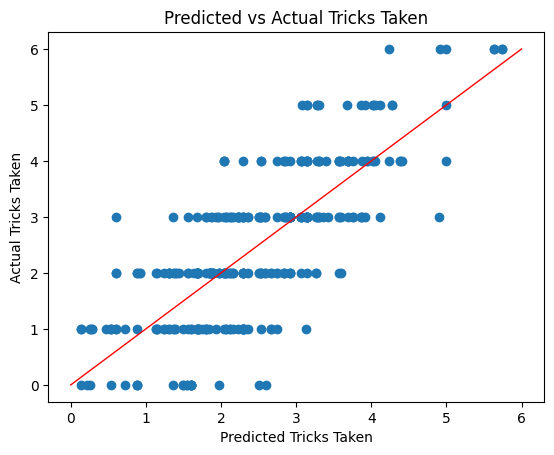

In [36]:
y_predict = rf.predict(X_test)
y_actual = y_test

# Plot the predicted vs actual
actual_vs_predicted_plot(y_predict, y_actual)